In [1]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD

# import LogisticRegression

In [2]:
df = pd.read_csv('IMDB.csv')

print(df.shape, df["sentiment"].value_counts())
df.head()

(50000, 2) positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['review']).toarray()
y = (df['sentiment'] == 'positive').astype(float) 

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        # we need 0.5 dropout to avoid overfitting
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [17]:
# SentimentClassifier(input_dim=X_train.shape[1])
# Assuming 1000 features from TF-IDF
model = SentimentClassifier(input_dim=1000)

# 3. Training setup
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4. Train the model
losses = []
num_epochs = 10
# loss per epoch
start_time = time.time()

epoch_times = []

for epoch in range(num_epochs):
    start_time_epoch = time.time()
    
    epoch_losses = []
    for i, (reviews, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(reviews)
        loss = criterion(outputs.squeeze(), labels)
        epoch_losses += [loss.item()]
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        if (i+1) % 250 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    losses.append(sum(epoch_losses) / len(epoch_losses))
    
    scheduler.step()
    
    end_time_epoch = time.time()
    
    epoch_times.append(end_time_epoch - start_time_epoch)

end_time = time.time()
duration = end_time - start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"--- {duration} seconds ---")
print(f"--- {avg_epoch_time} seconds per epoch ---")
print('Finished Training')

Epoch [1/10], Step [250/2500], Loss: 0.3035
Epoch [1/10], Step [500/2500], Loss: 0.2994
Epoch [1/10], Step [750/2500], Loss: 0.3455
Epoch [1/10], Step [1000/2500], Loss: 0.3043
Epoch [1/10], Step [1250/2500], Loss: 0.7757
Epoch [1/10], Step [1500/2500], Loss: 0.4900
Epoch [1/10], Step [1750/2500], Loss: 0.4083
Epoch [1/10], Step [2000/2500], Loss: 0.5820
Epoch [1/10], Step [2250/2500], Loss: 0.1855
Epoch [1/10], Step [2500/2500], Loss: 0.1296
Epoch [2/10], Step [250/2500], Loss: 0.6013
Epoch [2/10], Step [500/2500], Loss: 0.6187
Epoch [2/10], Step [750/2500], Loss: 0.4707
Epoch [2/10], Step [1000/2500], Loss: 0.4463
Epoch [2/10], Step [1250/2500], Loss: 0.4961
Epoch [2/10], Step [1500/2500], Loss: 0.4233
Epoch [2/10], Step [1750/2500], Loss: 0.2475
Epoch [2/10], Step [2000/2500], Loss: 0.2846
Epoch [2/10], Step [2250/2500], Loss: 0.1168
Epoch [2/10], Step [2500/2500], Loss: 0.2972
Epoch [3/10], Step [250/2500], Loss: 0.2471
Epoch [3/10], Step [500/2500], Loss: 0.2588
Epoch [3/10], Step

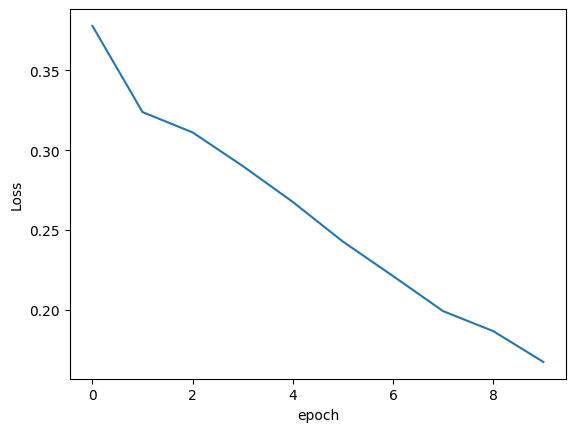

In [18]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


In [19]:
# validation and testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for reviews, labels in test_loader:
        outputs = model(reviews)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the model on the test reviews: {100 * correct / total}%')

Accuracy of the model on the test reviews: 85.74%
